In [103]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [337]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from collections import Counter

# NLP and Text Processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import cmudict
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Local
from classes.song import Song
from classes.playlist import Playlist
from classes.spotify_manager import SpotifyManager
from classes.lyrics_manager import LyricsManager
from classes.utils import gather_data_from_folders

import warnings
warnings.simplefilter('ignore')
load_dotenv();

# Loading the data

In [245]:
playlists_dir = 'audio_sentiment_classifier/playlists'
playlists_dir = os.path.join("/".join(os.path.abspath(os.path.realpath(__name__)).split("/")[:-1]), "playlists")
df = gather_data_from_folders(playlists_dir)

Loading CSV file: /home/krystian/Python/Jupyter-projects/thesis/songs_analysis/playlists/final download 1/final download 1.csv
Loading CSV file: /home/krystian/Python/Jupyter-projects/thesis/songs_analysis/playlists/final download 2/final download 2.csv


In [308]:
df.head()

,title,artist,mp3_path,lyrics,popularity,explicit,album_release_year,duration_ms,danceability,energy,...,young,za,ça,świat,że,noun_count,verb_count,vader_compound,repetition_count,average_syllables_per_word
0,skinny love,birdy,/home/krystian/Python/Jupyter-projects/thesis/...,"Come on, skinny love, just last the year\nPour...",71.0,False,2011,201080,0.379,0.290,...,0.0,0.0,0.0,0.0,0.0,39,42,0.9820,36,1.123016
1,deathwish,red sun rising,/home/krystian/Python/Jupyter-projects/thesis/...,Life is fleeting by the slow\nIt chills us to ...,NaN,False,2018,287946,0.508,0.882,...,0.0,0.0,0.0,0.0,0.0,69,89,-0.6506,68,1.167513
2,iris,the goo goo dolls,/home/krystian/Python/Jupyter-projects/thesis/...,And I'd give up forever to touch you\n'Cause I...,71.0,False,2007,289906,0.291,0.790,...,0.0,0.0,0.0,0.0,0.0,19,86,-0.5983,29,1.150407
3,the woods,hollow coves,/home/krystian/Python/Jupyter-projects/thesis/...,No lyrics found,NaN,False,2017,241546,0.802,0.410,...,0.0,0.0,0.0,0.0,0.0,1,1,-0.2960,0,1.333333
4,don't dream it's over,crowded house,/home/krystian/Python/Jupyter-projects/thesis/...,There is freedom within\nThere is freedom with...,NaN,False,2017,231377,0.403,0.746,...,0.0,0.0,0.0,0.0,0.0,58,61,-0.9925,47,1.187251


In [310]:
# Fixing the dtypes
int_columns = ['duration_ms', 'album_release_year']
df[int_columns] = df[int_columns].astype(int)

df.key = df.key.astype('category')
df['mode'] = df['mode'].astype('category')
df.time_signature = df.time_signature.astype('category')

In [311]:
spotify_features = ['popularity', 'explicit',
       'album_release_year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature']

lyrics_features = ['lyrics']

audio_extracted_features = ['mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
       'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6',
       'spectral_contrast_7', 'tempo_extracted', 'zcr']

# Additional language features calculation

In [249]:
# Download nltk data if not already available
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# Initialize the CMU pronouncing dictionary
d = cmudict.dict()
sid = SentimentIntensityAnalyzer()

def syllable_count(word):
    if word.lower() in d:
        return len([y for y in d[word.lower()][0] if y[-1].isdigit()])
    else:
        return len(re.findall(r'[aeiouy]+', word.lower())) or 1


def extract_features(df):
    features = pd.DataFrame()

    # Word Count
    features['word_count'] = df['lyrics'].apply(lambda x: len(x.split()))
    
    # Unique Word Count
    features['unique_word_count'] = df['lyrics'].apply(lambda x: len(set(x.split())))
    
    # Average Word Length
    features['avg_word_length'] = df['lyrics'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))
    
    # Syllable Count
    features['syllable_count'] = df['lyrics'].apply(lambda x: sum([syllable_count(word) for word in x.split()]))
    
    # Sentiment Polarity
    features['sentiment_polarity'] = df['lyrics'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    # Sentiment Subjectivity
    features['sentiment_subjectivity'] = df['lyrics'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    
    # Readability Score using textstat
    features['readability_score'] = df['lyrics'].apply(lambda x: textstat.flesch_kincaid_grade(x))
    
    # TF-IDF (you can customize the number of features)
    tfidf = TfidfVectorizer(max_features=500, stop_words="english")  # Replace ENGLISH_STOP_WORDS with "english"
    tfidf_features = pd.DataFrame(tfidf.fit_transform(df['lyrics']).toarray(), columns=tfidf.get_feature_names_out())
    features = pd.concat([features, tfidf_features], axis=1)
    
    # POS Tagging (e.g., noun count)
    def count_pos_tags(text, tag_prefix):
        tokens = word_tokenize(text)
        tagged = pos_tag(tokens)
        return sum(1 for word, tag in tagged if tag.startswith(tag_prefix))
    
    features['noun_count'] = df['lyrics'].apply(lambda x: count_pos_tags(x, 'NN'))
    features['verb_count'] = df['lyrics'].apply(lambda x: count_pos_tags(x, 'VB'))
    
    # Vader Sentiment Analysis
    features['vader_compound'] = df['lyrics'].apply(lambda x: sid.polarity_scores(x)['compound'])
    
    # Repetition Count (how many words are repeated)
    def repetition_count(text):
        words = text.split()
        word_freq = Counter(words)
        repeated_words = [word for word, count in word_freq.items() if count > 1]
        return len(repeated_words)
    features['repetition_count'] = df['lyrics'].apply(repetition_count)
    
    # Phoneme and Syllable-based features
    features['average_syllables_per_word'] = features['syllable_count'] / features['word_count']
    
    return features


features = extract_features(df).drop('lyrics', axis=1)

[nltk_data] Downloading package punkt to /home/krystian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/krystian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/krystian/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/krystian/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/krystian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [250]:
df = pd.concat([df, features], axis=1)

# Model

In [251]:
target = 'energy'

In [254]:
cat_features = [ f for f in df.select_dtypes(include=['category']).columns if f != target ]
num_features = [ f for f in df.select_dtypes(include=['number']).columns if f != target ]

In [255]:
df.head()

,title,artist,mp3_path,lyrics,popularity,explicit,album_release_year,duration_ms,danceability,energy,...,young,za,ça,świat,że,noun_count,verb_count,vader_compound,repetition_count,average_syllables_per_word
0,skinny love,birdy,/home/krystian/Python/Jupyter-projects/thesis/...,"Come on, skinny love, just last the year\nPour...",71.0,False,2011,201080,0.379,0.290,...,0.0,0.0,0.0,0.0,0.0,39,42,0.9820,36,1.123016
1,deathwish,red sun rising,/home/krystian/Python/Jupyter-projects/thesis/...,Life is fleeting by the slow\nIt chills us to ...,NaN,False,2018,287946,0.508,0.882,...,0.0,0.0,0.0,0.0,0.0,69,89,-0.6506,68,1.167513
2,iris,the goo goo dolls,/home/krystian/Python/Jupyter-projects/thesis/...,And I'd give up forever to touch you\n'Cause I...,71.0,False,2007,289906,0.291,0.790,...,0.0,0.0,0.0,0.0,0.0,19,86,-0.5983,29,1.150407
3,the woods,hollow coves,/home/krystian/Python/Jupyter-projects/thesis/...,No lyrics found,NaN,False,2017,241546,0.802,0.410,...,0.0,0.0,0.0,0.0,0.0,1,1,-0.2960,0,1.333333
4,don't dream it's over,crowded house,/home/krystian/Python/Jupyter-projects/thesis/...,There is freedom within\nThere is freedom with...,NaN,False,2017,231377,0.403,0.746,...,0.0,0.0,0.0,0.0,0.0,58,61,-0.9925,47,1.187251


In [256]:


# Split the data into features and target
X = df[num_features + cat_features]
y = df[target]

In [257]:
X

,popularity,album_release_year,duration_ms,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,świat,że,noun_count,verb_count,vader_compound,repetition_count,average_syllables_per_word,key,mode,time_signature
0,71.0,2011,201080,0.379,-8.487,0.0513,0.952000,0.000996,0.1180,0.184,...,0.0,0.0,39,42,0.9820,36,1.123016,4,1,4
1,NaN,2018,287946,0.508,-5.518,0.0518,0.006140,0.000003,0.3460,0.603,...,0.0,0.0,69,89,-0.6506,68,1.167513,8,0,4
2,71.0,2007,289906,0.291,-5.683,0.0363,0.001330,0.000006,0.0811,0.513,...,0.0,0.0,19,86,-0.5983,29,1.150407,11,0,3
3,NaN,2017,241546,0.802,-12.793,0.0454,0.411000,0.001070,0.0941,0.224,...,0.0,0.0,1,1,-0.2960,0,1.333333,9,1,4
4,NaN,2017,231377,0.403,-5.574,0.0404,0.044400,0.000259,0.1360,0.512,...,0.0,0.0,58,61,-0.9925,47,1.187251,8,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973,42.0,2016,216106,0.526,-6.151,0.0258,0.000075,0.907000,0.1090,0.282,...,0.0,0.0,47,45,-0.9083,43,1.421739,11,1,4
2974,30.0,2013,255506,0.722,-6.536,0.0540,0.414000,0.000000,0.0760,0.320,...,0.0,0.0,47,114,0.9922,68,1.133159,7,1,4
2975,45.0,2011,224866,0.379,-10.435,0.0329,0.983000,0.000166,0.1080,0.256,...,0.0,0.0,19,38,0.5204,30,1.187097,6,1,4
2976,23.0,2002,218960,0.597,-4.971,0.0407,0.319000,0.000000,0.4190,0.713,...,0.0,0.0,74,71,0.9112,51,1.186131,9,1,4


In [ ]:
def regression(X, y):
    def evaluate_regression_model(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
        
        results = {
            'Metric': ['Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'R-squared'],
            'Value': [mae, mse, rmse, r2]
        }
    
        return pd.DataFrame(results)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define a pipeline with feature selection, scaling, and model training
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(score_func=f_classif, k=20)),  # Select top 20 features
        ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
        # ('model', RandomForestClassifier(random_state=42))  # Random forest for classification
        ('model', RandomForestRegressor(random_state=42))  # Random forest for classification
    ])
    
    pipeline.fit(X_train, y_train)
        
    y_pred = pipeline.predict(X_test)
    
    model = pipeline.named_steps['model']
    
    feature_importances = model.feature_importances_
    
    selected_features = pipeline.named_steps['feature_selection'].get_support(indices=True)
    
    selected_feature_names = np.array(num_features + cat_features)[selected_features]
    
    sorted_idx = np.argsort(feature_importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.barh(selected_feature_names[sorted_idx], feature_importances[sorted_idx], color='b', align='center')
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance for Audio Sentiment Prediction')
    plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature on top
    plt.tight_layout()
    plt.show()
    
    evaluate_regression_model(y_test, y_pred)

/home/krystian/Python/VENVS/jupyter310/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


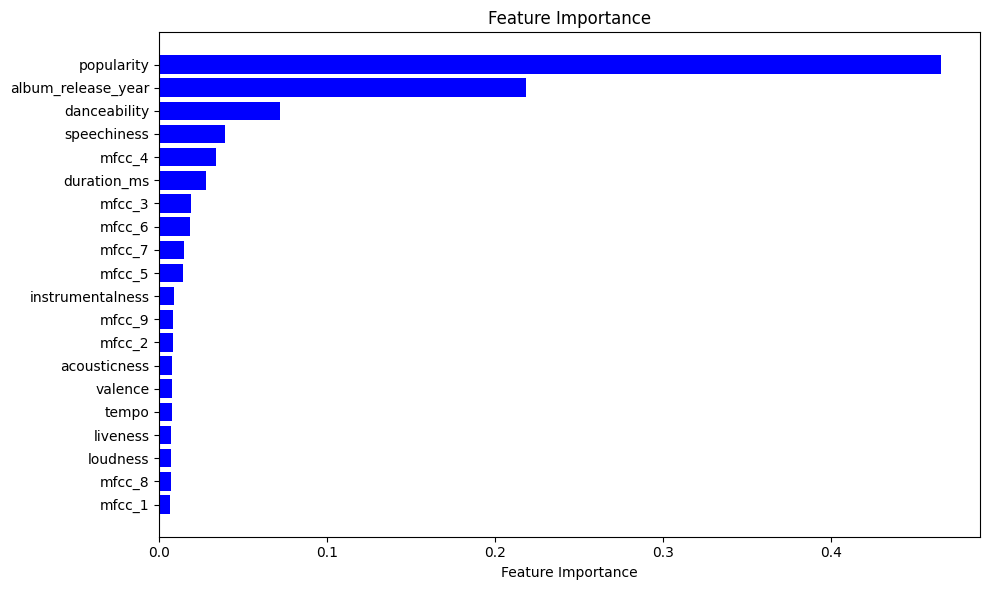

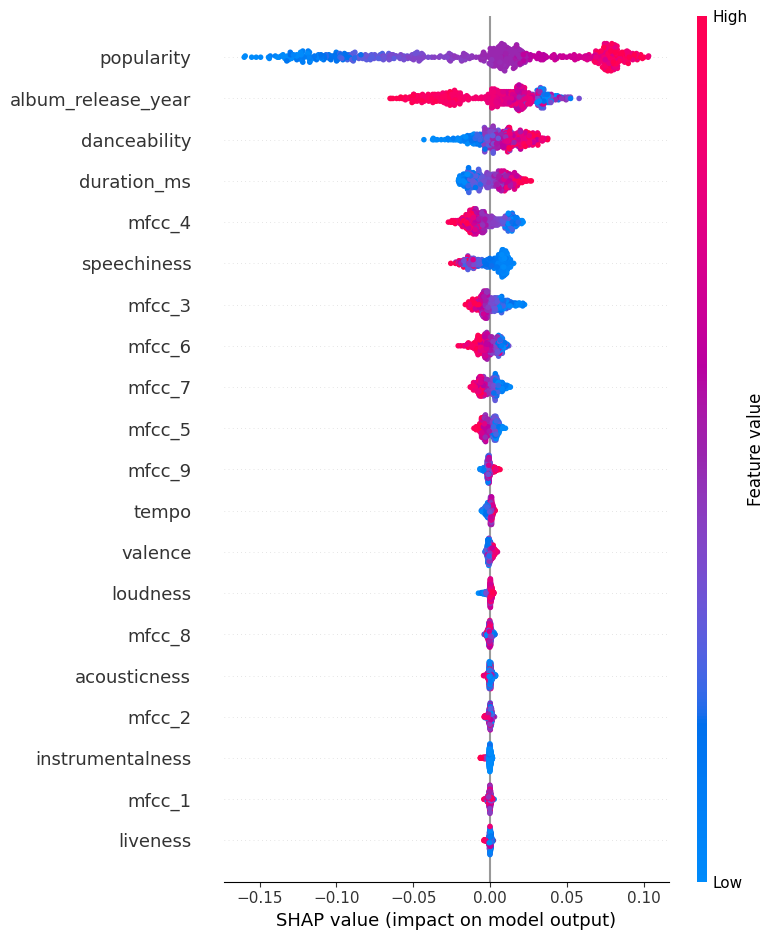

ValueError: X has 574 features, but RandomForestRegressor is expecting 20 features as input.

In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap  # SHAP values for explainability
from sklearn.inspection import permutation_importance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
from sklearn.inspection import permutation_importance

# Example function
def regression(X, y, numerical_features, categorical_features, model=None, target_transform=None, feature_selection=True, k=20):
    
    def evaluate_regression_model(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
        
        results = {
            'Metric': ['Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'R-squared'],
            'Value': [mae, mse, rmse, r2]
        }
    
        return pd.DataFrame(results)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Default model is RandomForestRegressor if no model is provided
    if model is None:
        model = RandomForestRegressor(random_state=42)

    # Preprocessing for numerical features: Imputation and scaling
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    # Preprocessing for categorical features: OneHotEncoder
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # ColumnTransformer to apply preprocessing to respective columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Target transformation (log transformation or others)
    if target_transform == 'log':
        target_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, check_inverse=False)
    else:
        target_transformer = None

    # Combine feature selection if needed
    if feature_selection:
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('feature_selection', SelectKBest(score_func=f_regression, k=k)),
            ('model', model)
        ])
    else:
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    # If a target transformer is provided, use TransformedTargetRegressor
    if target_transformer:
        pipeline = TransformedTargetRegressor(regressor=model_pipeline, transformer=target_transformer)
    else:
        pipeline = model_pipeline

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    eval_results = evaluate_regression_model(y_test, y_pred)

    # Feature importance from the model
    model = pipeline.regressor_.named_steps['model'] if target_transformer else pipeline.named_steps['model']
    if hasattr(model, 'feature_importances_'):  # Check if the model has feature_importances_ attribute
        feature_importances = model.feature_importances_

        # Get feature names
        selected_feature_names = numerical_features + list(pipeline.regressor_.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)) if target_transformer else numerical_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features))

        # Plot feature importance
        sorted_idx = np.argsort(feature_importances)[::-1]
        plt.figure(figsize=(10, 6))
        plt.barh(np.array(selected_feature_names)[sorted_idx], feature_importances[sorted_idx], color='b', align='center')
        plt.xlabel('Feature Importance')
        plt.title('Feature Importance')
        plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature on top
        plt.tight_layout()
        plt.show()

    # SHAP values for model explainability (works for tree-based models like RandomForest)
    explainer = shap.TreeExplainer(model)
    
    # Transform the test set to the format used by the model
    X_test_transformed = pipeline.regressor_.named_steps['preprocessor'].transform(X_test) if target_transformer else pipeline.named_steps['preprocessor'].transform(X_test)
    
    shap_values = explainer.shap_values(X_test_transformed)
    shap.summary_plot(shap_values, X_test_transformed, feature_names=selected_feature_names)

    # Permutation Importance for more robust feature ranking
    perm_importance = permutation_importance(model, X_test_transformed, y_test, n_repeats=10, random_state=42)
    sorted_idx = perm_importance.importances_mean.argsort()
    
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(selected_feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title("Permutation Importance")
    plt.tight_layout()
    plt.show()

    return eval_results

results = regression(X, y, num_features, cat_features, model=RandomForestRegressor(random_state=42), target_transform='log', feature_selection=True, k=20)
results

---

In [258]:
def evaluate_regression_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    
    results = {
        'Metric': ['Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'R-squared'],
        'Value': [mae, mse, rmse, r2]
    }

    return pd.DataFrame(results)

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)

# Preprocessing for numerical features: Imputation and scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features: OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for categorical features: OneHotEncoder
target_transformer = Pipeline(steps=[
    ('log_transformer', FunctionTransformer(np.log1p, inverse_func=np.expm1, check_inverse=False)),
    ('scaler', StandardScaler())
])

# ColumnTransformer to apply preprocessing to respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features),
    ]
)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('feature_selection', SelectKBest(score_func=f_regression, k=20)),
    ('model', model)
])

final_pipeline = TransformedTargetRegressor(regressor=model_pipeline, transformer=target_transformer)
final_pipeline

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer()),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['popularity',
                                                                                        'album_release_year',
                                                                                        'duration_ms',
                                                                                        'danceability',
                                                                                        'loudness',
                                                                                        'speechiness',
                                                                                        'acousticness',
                                                                                        'instrumentalness',
                                                                                        'liveness',
                                                                                        'valence',
                                                                                        'tempo',
                                                                                        'mfcc_1',
                                                                                        'mfcc_2...
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='most_frequent')),
                                                                                                       ('onehot',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['key',
                                                                                        'mode',
                                                                                        'time_signature'])])),
                                                     ('model',
                                                      RandomForestRegressor(random_state=42))]),
                           transformer=Pipeline(steps=[('log_transformer',
                                                        FunctionTransformer(check_inverse=False,
                                                                            func=<ufunc 'log1p'>,
                                                                            inverse_func=<ufunc 'expm1'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

In [285]:
final_pipeline.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer()),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['popularity',
                                                                                        'album_release_year',
                                                                                        'duration_ms',
                                                                                        'danceability',
                                                                                        'loudness',
                                                                                        'speechiness',
                                                                                        'acousticness',
                                                                                        'instrumentalness',
                                                                                        'liveness',
                                                                                        'valence',
                                                                                        'tempo',
                                                                                        'mfcc_1',
                                                                                        'mfcc_2...
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='most_frequent')),
                                                                                                       ('onehot',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['key',
                                                                                        'mode',
                                                                                        'time_signature'])])),
                                                     ('model',
                                                      RandomForestRegressor(random_state=42))]),
                           transformer=Pipeline(steps=[('log_transformer',
                                                        FunctionTransformer(check_inverse=False,
                                                                            func=<ufunc 'log1p'>,
                                                                            inverse_func=<ufunc 'expm1'>)),
                                                       ('scaler',
                                                        StandardScaler())]))

In [286]:
y_pred = final_pipeline.predict(X_test)

eval_results = evaluate_regression_model(y_test, y_pred)
eval_results

/home/krystian/Python/VENVS/jupyter310/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Metric,Value
0,Mean Absolute Error,0.072330
1,Mean Squared Error,0.008454
2,Root Mean Squared Error,0.091943
3,R-squared,0.813677


/tmp/ipykernel_2313566/1368144928.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="viridis")


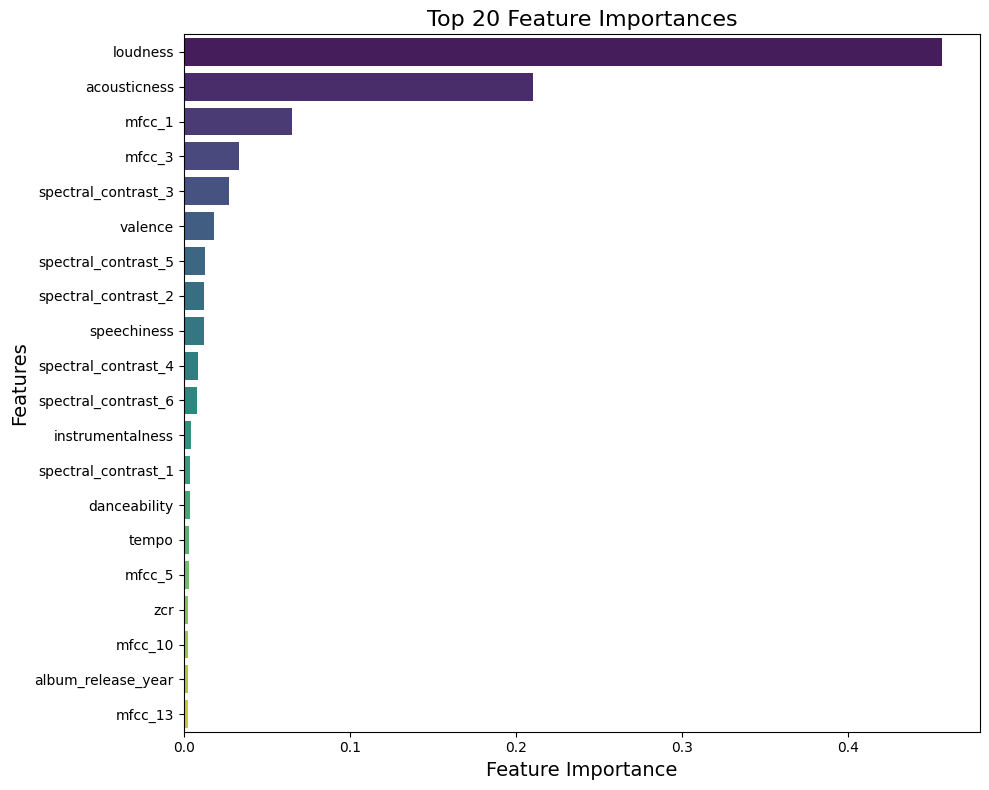

In [301]:
# Extract the model from the pipeline
model = final_pipeline.regressor_.named_steps['model']

feature_importances = model.feature_importances_

# Get feature names for numerical and categorical features
selected_feature_names = num_features + list(final_pipeline.regressor_.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(cat_features)) if target_transformer else num_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(cat_features))

# Sort feature importances in descending order and select top 20
sorted_idx = np.argsort(feature_importances)[::-1][:20]
top_features = np.array(selected_feature_names)[sorted_idx]
top_importances = feature_importances[sorted_idx]

# Create a seaborn barplot for the top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(x=top_importances, y=top_features, palette="viridis")
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 20 Feature Importances', fontsize=16)
plt.tight_layout()
plt.show()

# SHAP

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.inspection import permutation_importance

# Transform the test set to the format used by the model
X_test_transformed = final_pipeline.regressor_.named_steps['preprocessor'].transform(X_test)

# SHAP values for model explainability
# explainer = shap.TreeExplainer(model)

# Get feature names (already defined earlier)
selected_feature_names = num_features + list(final_pipeline.regressor_.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(cat_features))

# Calculate SHAP values with additivity check disabled
# shap_values = explainer.shap_values(X_test_transformed, check_additivity=False)

# Create a SHAP values object with correct feature names
shap_values_with_names = shap.Explanation(values=shap_values, feature_names=selected_feature_names)

## Barplot

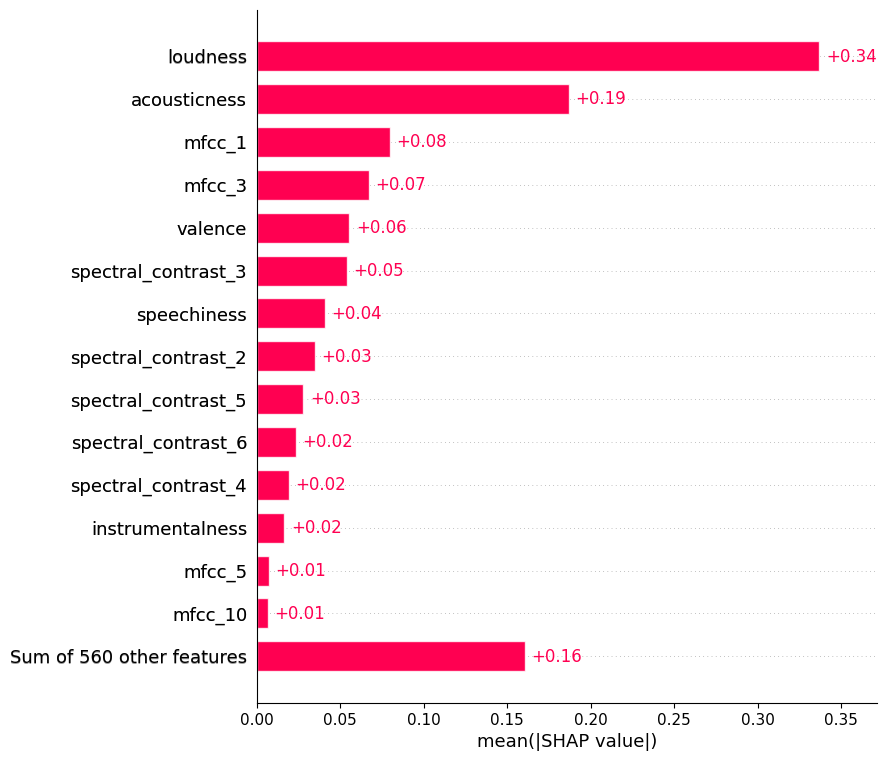

In [ ]:
# Plot SHAP values with the correct feature names
shap.plots.bar(shap_values_with_names, max_display=15)

## Beeswarm plot

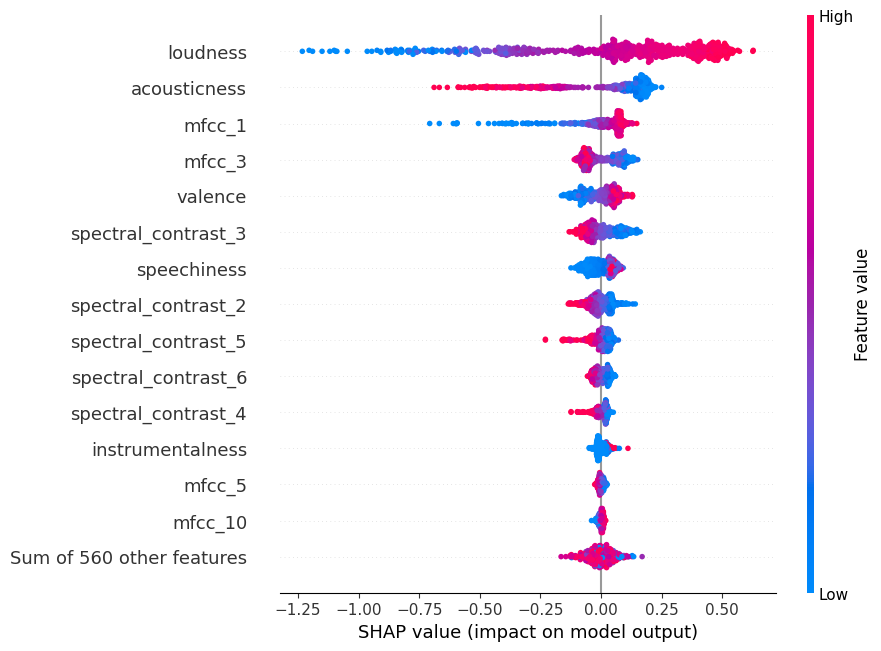

In [338]:
shap.plots.beeswarm(shap_values_with_names, max_display=15)